Imports

In [1]:
# ! pip install -r requirements.txt

In [2]:
ROOT = '/home/sms/Github/epimage/eeg'

In [17]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import yaml
import numpy as np
from mne.io import *
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from nilearn.glm.first_level import spm_hrf

In [4]:
sys.path.insert(0, ROOT)
os.chdir(ROOT)

Configuration

In [5]:
from dataloader import load_config, load_raw, load_electrodes
from preprocess import clean
config = load_config('config/config.yml')

Config file loaded from: config/config.yml


Paths

In [6]:
data_dir = os.path.join(config["paths"]["eeg_dir"], config["paths"]["subject_dir"])
eeg_outside_path = os.path.join(data_dir, config["paths"]["eeg_outside"])
eeg_inside_path = os.path.join(data_dir, config["paths"]["eeg_inside"])
spike_timing_path = os.path.join(data_dir, config["paths"]["spike_timinmg"])
sfreq = config["hyperparameters"]["sfreq"]
tr = config["hyperparameters"]["tr"]
os.makedirs('results', exist_ok=True)

Electrodes Postions

In [7]:
electrode_positions = config["electrode_positions_10-10"] # 'electrode_positions_10-20' to limit to 19 electrodes
electrode_labels = list(electrode_positions.keys())
electrode_positions_used = {label: electrode_positions[label] for label in electrode_labels}

EEG Data

In [8]:
eeg_outside = load_raw(eeg_outside_path, preload=True)
eeg_outside.pick_channels(electrode_labels)
eeg_outside_data = eeg_outside.get_data()
n_channels, n_samples = eeg_outside_data.shape
print(eeg_outside.info)
# eeg_outside.plot(scalings='auto', title="Raw EEG")

Reading /home/sms/Github/datasets/eeg/sub01/preprocessed/outside_preprocessed.fdt
Reading 0 ... 107869  =      0.000 ...   431.476 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 250.0 Hz
>


In [9]:
eeg_inside = load_raw(eeg_inside_path, preload=True)
eeg_inside.pick_channels(electrode_labels)
eeg_inside_data = eeg_inside.get_data()
n_channels, n_samples = eeg_inside_data.shape
print(eeg_inside.info)
# eeg_outside.plot(scalings='auto', title="Raw EEG")

Reading /home/sms/Github/datasets/eeg/sub01/preprocessed/inside_fMRIb_BCG_ICA.fdt
Reading 0 ... 67500  =      0.000 ...   270.000 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 250.0 Hz
>


Outside Scanner IEDs timing

In [10]:
spike_timing = (np.loadtxt(spike_timing_path, dtype=float) * sfreq).astype('int')

Preprocess EEG (outside scanner)

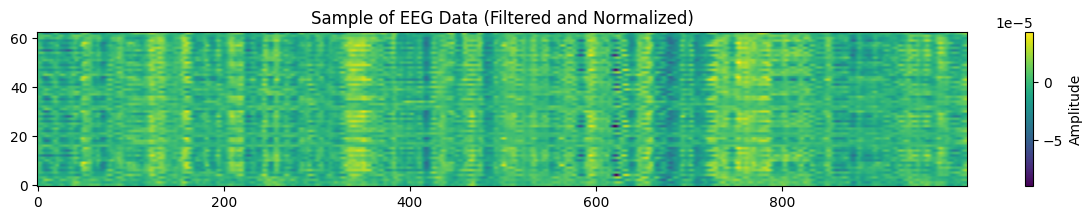

In [11]:
eeg_outside_filtered = clean(eeg_outside_data, sfreq=250, low=1.0, high=30.0)

plt.figure(figsize=(15, 2))
plt.title("Sample of EEG Data (Filtered and Normalized)")
plt.imshow(eeg_outside_filtered[:,:1000], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.savefig("results/eeg_outside.png", dpi=300, bbox_inches='tight')
plt.show()

Preprocess EEG (inside scanner)

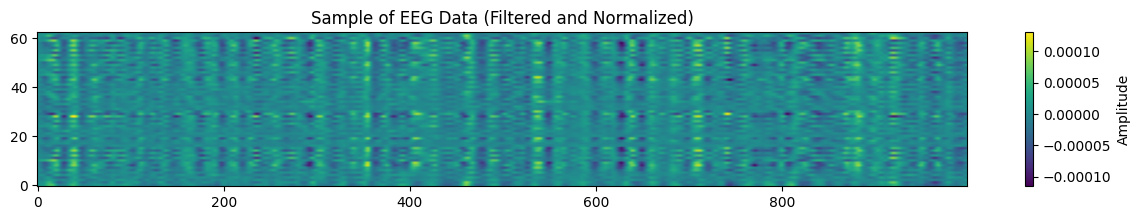

In [13]:
eeg_inside_filtered = clean(eeg_inside_data, sfreq=250, low=1.0, high=30.0)

plt.figure(figsize=(15, 2))
plt.title("Sample of EEG Data (Filtered and Normalized)")
plt.imshow(eeg_inside_filtered[:,:1000], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.savefig("results/eeg_inside.png", dpi=300, bbox_inches='tight')
plt.show()

Activity Map with Topography

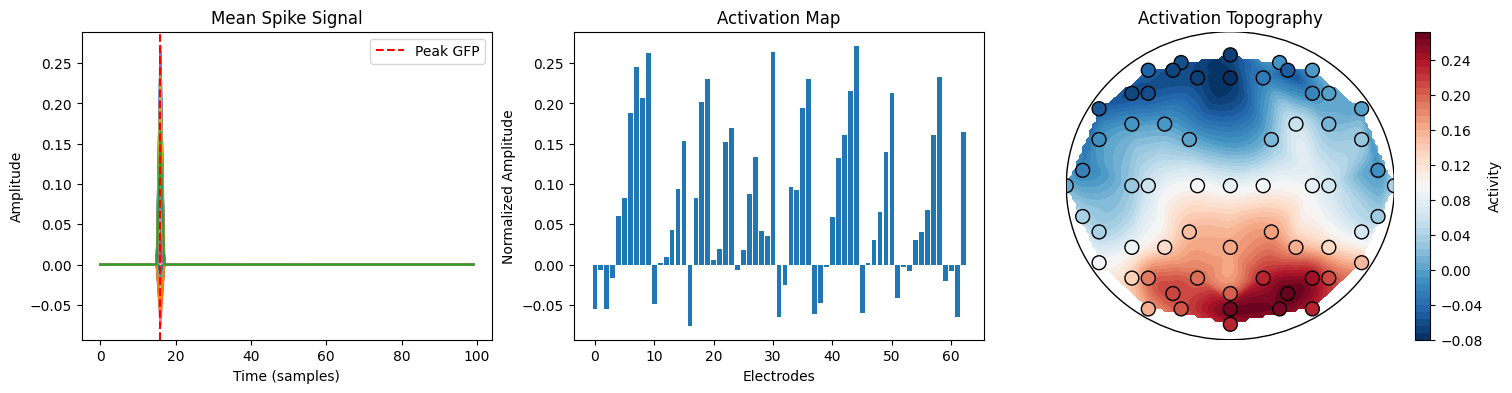

In [14]:
def activity_map(eeg_data, spike_timing):
    
    spike_data = []
    window = 50

    for t in spike_timing:
        if t - window >= 0 and t + window < eeg_data.shape[1]:
            spike_data.append(eeg_data[:, t - window:t + window])

    spike_data = np.array(spike_data)
    mean_spike = np.mean(spike_data, axis=0)

    # Normalize by Global Field Power (GFP)
    gfp = np.std(mean_spike, axis=0)
    peak_idx = np.argmax(gfp)
    epileptic_map = mean_spike[:, peak_idx]
    epileptic_map /= np.linalg.norm(epileptic_map)  # Normalize to unit norm

    return epileptic_map, mean_spike, gfp, peak_idx


def generate_topography(activity_values, electrode_positions, plot=True):
    
    if len(activity_values) != len(electrode_positions):
        raise ValueError("Mismatch between activity values and electrode positions.")

    x, y = zip(*electrode_positions.values())
    x, y = np.array(x), np.array(y)

    grid_x, grid_y = np.mgrid[-1:1:100j, -1:1:100j]
    z = griddata((x, y), activity_values, (grid_x, grid_y), method='cubic')

    mask = np.sqrt(grid_x**2 + grid_y**2) > 1
    z[mask] = np.nan
    
    if plot:
        plt.contourf(grid_x, grid_y, z, levels=50, cmap='RdBu_r')
        plt.colorbar(label='Activity')
        plt.scatter(x, y, c=activity_values, cmap='RdBu_r', edgecolor='k', s=100)
        
        circle = plt.Circle((0, 0), 1, color='k', fill=False)
        plt.gca().add_artist(circle)

        plt.axis('off')
        plt.title('Activation Topography')

    return z


epileptic_map, mean_spike, gfp, peak_idx = activity_map(eeg_outside_filtered, spike_timing)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.title("Mean Spike Signal")
plt.plot(mean_spike.T)
plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak GFP')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Activation Map")
plt.bar(range(len(epileptic_map)), epileptic_map)
plt.xlabel("Electrodes")
plt.ylabel("Normalized Amplitude")

plt.subplot(1, 3, 3)
epileptic_topography = generate_topography(epileptic_map, electrode_positions_used)

plt.savefig(f"results/spike_map_{n_channels}ch.png", dpi=300, bbox_inches='tight')
plt.show()

Spatial Correlation

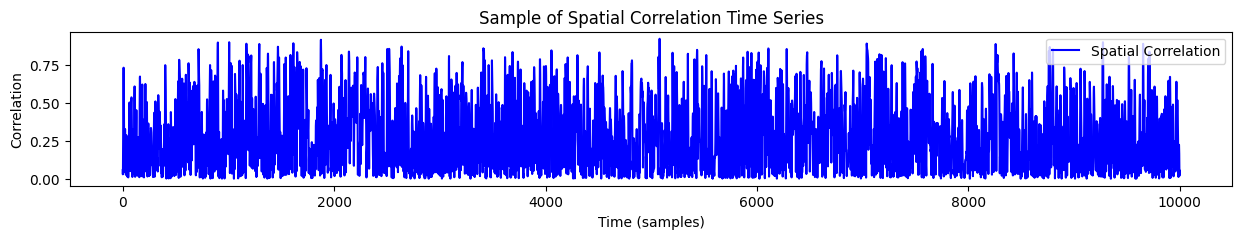

In [15]:
def spatial_corr(eeg_data, epileptic_map):
    
    correlations = []
    for t in range(eeg_data.shape[1]):
        frame = eeg_data[:, t]
        corr = np.corrcoef(frame, epileptic_map)[0, 1]
        correlations.append(abs(corr))  # Use absolute value of correlation

    return np.array(correlations)


def spatial_corr_with_topography(eeg_data, epileptic_topography, electrode_positions):

    correlations = []
    for t in range(eeg_data.shape[1]):
        frame_activity = eeg_data[:, t]

        if len(frame_activity) != len(electrode_positions):
            raise ValueError("Mismatch between activity values and electrode positions.")

        frame_topography = generate_topography(frame_activity, electrode_positions, plot=False)

        valid_idx = ~np.isnan(epileptic_topography) & ~np.isnan(frame_topography)
        if np.any(valid_idx):
            corr = np.corrcoef(
                epileptic_topography[valid_idx].flatten(),
                frame_topography[valid_idx].flatten()
            )[0, 1]
            correlations.append(abs(corr))
        else:
            correlations.append(0)

    return np.array(correlations)

correlation_series = spatial_corr_with_topography(eeg_inside_filtered, epileptic_topography, electrode_positions_used)
np.savetxt("results/correlation_series.txt", correlation_series, fmt="%.6f", newline="\n")

plt.figure(figsize=(15, 2))
plt.title("Sample of Spatial Correlation Time Series")
plt.plot(correlation_series[:10000], label='Spatial Correlation', color='b')
plt.xlabel("Time (samples)")
plt.ylabel("Correlation")
plt.legend()
plt.savefig("results/correlation_series.png", dpi=300, bbox_inches='tight')
plt.show()

Convolution with HRF

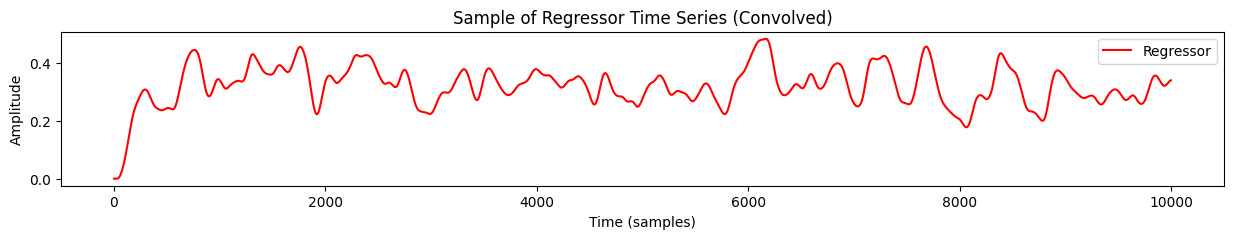

In [18]:
def conv_hrf(correlation_series, tr, hrf=None):
    if hrf is None:
        hrf = spm_hrf(tr)
    regressor = np.convolve(correlation_series, hrf)[:len(correlation_series)]
    return regressor

regressor = conv_hrf(correlation_series, tr)
np.savetxt("results/regressor.txt", correlation_series, fmt="%.6f", newline="\n")

plt.figure(figsize=(15, 2))
plt.title("Sample of Regressor Time Series (Convolved)")
plt.plot(regressor[:10000], label='Regressor', color='r')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.savefig("results/regressor.png", dpi=300, bbox_inches='tight')
plt.show()